# Event-related Analysis: How to Build Epochs

This example shows how to use NeuroKit to extract epochs from data based on events localisation.

## Understanding the Data

In this example, we will download the data, which contains 2.5 minutes of data recorded at a frequency of 100Hz (2.5 x 60 x 100 = 15000 data points). 


In [2]:
# Load the NeuroKit package and related dependencies
import neurokit2 as nk
import pandas as pd
import numpy as np
import seaborn as sns

# Get data
data = pd.read_csv("https://raw.githubusercontent.com/neuropsychology/NeuroKit/master/data/example_bio_100hz.csv")

This experiment consisted of 4 events (when the photosensor signal goes down), which were 2 types of images that were shown to the participant: "Negative" in emotionality vs "Neutral" in emotionality. Each picture was presented for 3 seconds. The following list is the condition order.

In [3]:
condition_list = ["Negative", "Neutral", "Neutral", "Negative"]

## Find Events

The data was obtained using 4 channels, namely the EDA, ECG, RSP and the Photosensor. We should find the onsets of events that are within our photosensor's signal, which can be localized and extracted using [events_find()](https://neurokit2.readthedocs.io/en/latest/functions.html#neurokit2.events_find). Note that you should also specify the `threshold_keep` to select events that are higher or below the threshold.

In [4]:
# Find events
events = nk.events_find(data["Photosensor"], threshold_keep='below', event_conditions=condition_list)
events

{'onset': array([ 1024,  4957,  9224, 12984]),
 'duration': array([300, 300, 300, 300]),
 'label': array(['1', '2', '3', '4'], dtype='<U11'),
 'condition': ['Negative', 'Neutral', 'Neutral', 'Negative']}

As we can see, `events_find()` returns a dict containing onsets and durations for each corresponding event, based on the label for event identifiers and each event condition. Each event here lasts for0 300 data points (equivalent to 3 seconds sampled at 100Hz).

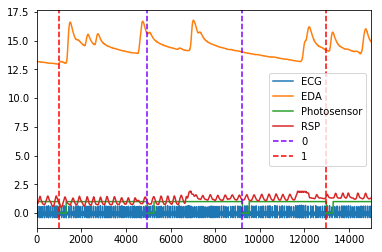

In [5]:
# Plot events
plot = nk.events_plot(events, data)

The output of [events_plot()](https://neurokit2.readthedocs.io/en/latest/functions.html#neurokit2.events_plot) shows the corresponding events in the signal, with the blue dashed line representing a Negative event and red dashed line representing a Neutral event.

## Process the Signals

Biosignals processing can be done quite easily using NeuroKit with the `bio_process()` function. Simply provide the appropriate biosignal channels and additional channels that you want to keep (for example, the photosensor), and `bio_process()` will take care of the rest. It will return a dict containing dataframes of all the relevant signals and their features.

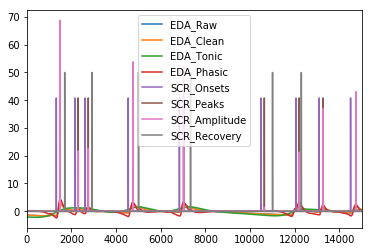

In [11]:
# Process the signal
bio = bio_process(ecg=data["ECG"], rsp=data["RSP"], eda=data["EDA"], emg=None, keep=data["Photosensor"], sampling_rate=100)
# Plot the processed dataframe, normalizing all variables for viewing purpose
nk.standardize(bio["EDA"]).plot()

## Create Epochs

We not have to categorize the dataframe in epochs, i.e. segments of data around the event using [epochs_create()](https://neurokit2.readthedocs.io/en/latest/functions.html#neurokit2.epochs_create). We set our epochs to start one second before the event onset and to last for 700 data points i.e., 7 s (since the signal is sampled at 100Hz). These are passed into the `epochs_start` and `epochs_duration` arguments respectively.

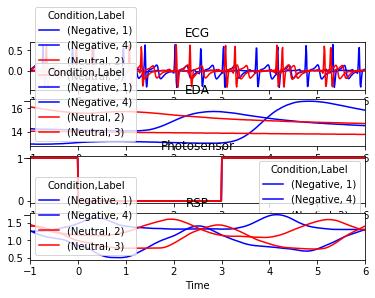

In [5]:
# Build and plot epochs
epochs = nk.epochs_create(data, events, sampling_rate=100, epochs_start=-1, epochs_duration=7)
plot = nk.epochs_plot(epochs)

Let's plot the first epoch.

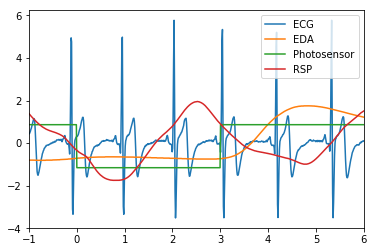

In [6]:
# Select the first epoch to plot
first_epoch = list(epochs.values())[0]
zscore_epoch = nk.standardize(first_epoch.loc[:,['ECG', 'EDA', 'Photosensor', 'RSP']])
zscore_epoch.plot()

## Extract Event Related Features

With this, we are able to compare how the physiological signals vary across the different events. We do this by iterating through the epochs and storing the results in a new dictionary which is converted into a dataframe, as shown below.



In [22]:
df = {}  # Initialize an empty dict
for epoch_index in epochs:
    df[epoch_index] = {}  # Initialize an empty dict for the current epoch
    epoch = epochs[epoch_index]

    # ECG
    baseline = epoch["ECG"].loc[-100:0].mean()  # Baseline
    rr_max = epoch["ECG"].loc[0:400].max()  # Maximum RR interval
    df[epoch_index]["HRV_MaxRR"] = rr_max - baseline  # Corrected for baseline
    
    # EDA - SCR
    scr_max = epoch["EDA"].loc[0:600].max()  # Maximum SCR peak
    if np.isnan(scr_max):
        scr_max = 0  # If no SCR, consider the magnitude, i.e.  that the value is 0
    df[epoch_index]["SCR_Magnitude"] = scr_max

df = pd.DataFrame.from_dict(df, orient="index")  # Convert to a dataframe
df["Condition"] = condition_list  # Add the conditions
df  # Print DataFrame

,HRV_MaxRR,SCR_Magnitude,Condition
1,0.653589,16.601256,Negative
2,0.636437,15.720519,Neutral
3,0.636893,14.018096,Neutral
4,0.642839,15.731658,Negative


## Plot Epoch Features


You can now plot all these individual heart beats, synchronized by their R peaks with the [epochs_plot()](https://neurokit2.readthedocs.io/en/latest/functions.html#neurokit2.epochs_plot) function.


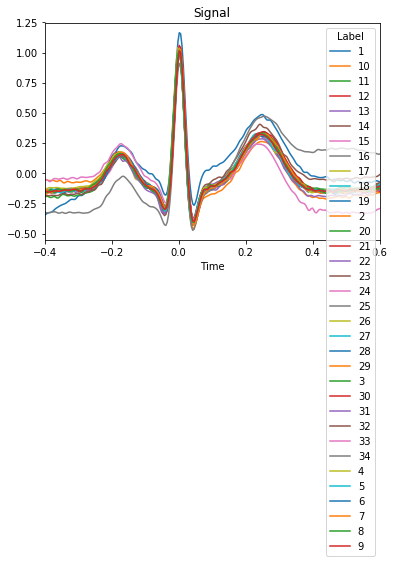

In [24]:
# Plotting all the heart beats
plot = nk.epochs_plot(epochs)